Inverse Problem (solvers)
============================


Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.3 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.3,<2.3"

As always, let's do imports and initialize a logger and a new Bundle.  See the [building a system tutorial](building_a_system.ipynb) for more details.

In [1]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

For the sake of a simple crude example, we'll just use the synthetic light curve of a default binary as our "observations".   See the [solver example scripts](../examples.md) for more realistic examples.

In [2]:
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,101))
b.run_compute(irrad_method='none')
times = b.get_value('times', context='model')
fluxes = b.get_value('fluxes', context='model')

b = phoebe.default_binary()
b.add_dataset('lc', times=times, fluxes=fluxes, sigmas=np.full_like(fluxes, fill_value=0.1))

<ParameterSet: 42 parameters | contexts: figure, dataset, constraint, compute>

Available Solvers
----------------------------------

PHOEBE includes wrappers around several different inverse-problem "algorithms" with a common interface.  These available "algorithms" are divided into three categories:

* estimators: provides proposed values for a number of parameters from the datasets as input alone, not requiring full forward-models via [run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md).
* optimizers: runs off-the-shelf optimizers to attempt to find the local (or global) solution.
* samplers: samples the local parameter space to estimate uncertainties and correlations.

To see the currently implemented set of solvers, we can call [phoebe.list_available_solvers](../api/phoebe.list_available_solvers.md)

In [3]:
print(phoebe.list_available_solvers())

['estimator.ebai', 'estimator.lc_geometry', 'estimator.lc_periodogram', 'estimator.rv_geometry', 'estimator.rv_periodogram', 'optimizer.cg', 'optimizer.nelder_mead', 'optimizer.powell', 'sampler.dynesty', 'sampler.emcee']


As there are quite a few and each have their own available options, we won't get in to the details here.  See the [solver API docs](../api/phoebe.parameters.solver.md) for details or look through some of the [solver example scripts](../examples.md).

As you may expect, to use a solver you must first call [b.add_solver](../api/phoebe.frontend.bundle.Bundle.add_solver.md), set the desired options, and then call [b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md) (or [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md)).

In [4]:
b.add_solver('estimator.lc_geometry', solver='my_lcgeom_solver')

<ParameterSet: 5 parameters | qualifiers: expose_model, t0_near_times, lc_datasets, orbit, comments>

In [5]:
print(b.get_solver(solver='my_lcgeom_solver'))

ParameterSet: 5 parameters
   comments@my_lcgeom_solver@s...: 
   lc_datasets@my_lcgeom_solve...: ['*']
    orbit@my_lcgeom_solver@solver: binary
   t0_near_times@my_lcgeom_sol...: True
   expose_model@my_lcgeom_solv...: True


In addition to the [solver API docs](../api/phoebe.parameters.solver.md), remember that each parameter has a description and possibly a set of available choices (if its a [ChoiceParameter](../api/phoebe.parameters.ChoiceParameter.md) or [SelectParameter](../api/phoebe.parameters.SelectParameter.md).

In [6]:
print(b.get_parameter('expose_model').description)

Whether to expose the 2-gaussian analytical models in the solution


run_solver
---------------

[b.run_solver](../api/phoebe.frontend.bundle.Bundle.run_solver.md) (or [b.export_solver](../api/phoebe.frontend.bundle.Bundle.export_solver.md) and [b.import_solution](../api/phoebe.frontend.bundle.Bundle.import_solution.md)) allows optionally setting a `solution` tag (if not provided, one will be created automatically, just as [b.run_compute](../api/phoebe.frontend.bundle.Bundle.run_compute.md) allows setting a `model` tag.  

In [7]:
b.run_solver(solver='my_lcgeom_solver', solution='my_lcgeom_solution')

/home/kyle/.local/lib/python3.7/site-packages/phoebe/solverbackends/lc_geometry.py:73: RuntimeWarning: invalid value encountered in greater
  ph_cross = phases[fluxes - np.nanmedian(fluxes) > 0]


<ParameterSet: 22 parameters | qualifiers: input_fluxes, input_sigmas, adopt_values, fitted_twigs, fitted_values, secondary_width, adopt_parameters, input_phases, fitted_uniqueids, primary_phase, orbit, secondary_phase, secondary_depth, fitted_units, analytic_fluxes, analytic_best_model, eclipse_edges, primary_width, primary_depth, adopt_distributions, comments, analytic_phases>

In many cases, the `solution` itself is plottable - showing some sort of diagnostic figures.

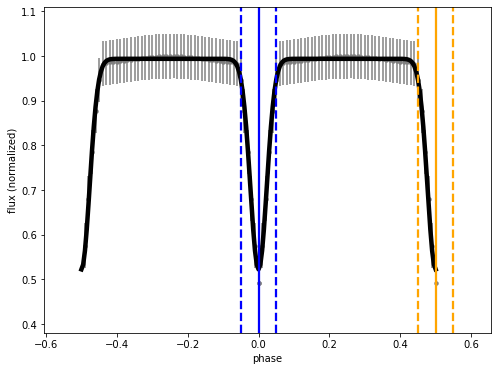

In [8]:
_ = b.plot(context='solution', solution='my_lcgeom_solution', show=True)

The proposed values can be viewed (by passing `trial_run=True`, in which case constrained values will not be shown) and/or directly adopted as face-values in the bundle via:

* [b.adopt_solution](../api/phoebe.frontend.bundle.Bundle.adopt_solution.md)

In [9]:
print(b.adopt_solution(trial_run=True))

Tue, 19 May 2020 11:28 BUNDLE       WARNING solution='my_lcgeom_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings


ParameterSet: 3 parameters
   t0_supconj@binary@orbit@com...: 4.797204572834367e-07 d
       ecc@binary@orbit@component: 7.535431323372434e-07
      per0@binary@orbit@component: 180.0 deg


In [10]:
print(b.adopt_solution())

Tue, 19 May 2020 11:28 BUNDLE       WARNING solution='my_lcgeom_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Tue, 19 May 2020 11:28 PARAMETERS   WARNING wrapping value of mean_anom to 269.9999180503454 deg


ParameterSet: 11 parameters
      t0_supconj@binary@component: 4.797204572834367e-07 d
             ecc@binary@component: 7.535431323372434e-07
            per0@binary@component: 180.0 deg
C     t0_perpass@binary@component: 0.2500002398602286 d
C         t0_ref@binary@component: 2.398602286043804e-07 d
C     compute_phases@lc01@dataset: []
C          ecosw@binary@component: -7.535431323372434e-07
C          esinw@binary@component: 9.228241850362754e-23
C    requiv_max@primary@component: 2.013273933106911 solRad
C  requiv_max@secondary@component: 2.013273933106911 solRad
C      mean_anom@binary@component: 269.9999180503454 deg


The Merit Function
-----------------

Both [optimizers](../api/phoebe.parameters.solver.optimizer.md) and [samplers](../api/phoebe.parameters.solver.sampler.md) require running a forward model and use a merit function to compare the synthetic model to the observational data.  This merit function is described in detail in the 2.3 release paper ([Conroy+ 2020](http://phoebe-project.org/publications/2020Conroy+)).

Several bundle methods allow for accessing the values used in the merit function:

* [b.calculate_residuals](../api/phoebe.parameters.ParameterSet.calculate_residuals.md)
* [b.calculate_chi2](../api/phoebe.parameters.ParameterSet.calculate_chi2.md)
* [b.calculate_lnlikelihood](../api/phoebe.parameters.ParameterSet.calculate_lnlikelihood.md)
* [b.calculate_lnp](../api/phoebe.frontend.bundle.Bundle.calculate_lnp.md)

The log-probability used as the merit function within optimizers and samplers is defined as [calculate_lnp](../api/phoebe.frontend.bundle.Bundle.calculate_lnp.md)(priors, combine=priors_combine) + [calculate_lnlikelihood](../api/phoebe.parameters.ParameterSet.calculate_lnlikelihood).

To see the affect of `priors_combine`, we can pass the `solver` tag directly to [b.get_distribution_collection](../api/phoebe.frontend.bundle.Bundle.get_distribution_collection.md), [b.plot_distribution_collection](../api/phoebe.frontend.bundle.Bundle.plot_distribution_collection.md), or [b.calculate_lnp](../api/phoebe.frontend.bundle.Bundle.calculate_lnp.md).

In [11]:
b.add_distribution('teff@primary', phoebe.gaussian(6000,100), distribution='mydist01')
b.add_distribution('teff@secondary', phoebe.gaussian(5500,600), distribution='mydist01')

b.add_distribution('teff@primary', phoebe.uniform(5800,6200), distribution='mydist02')

<ParameterSet: 1 parameters>

In [12]:
b.add_solver('sampler.emcee', priors=['mydist01', 'mydist02'], solver='myemceesolver')

Tue, 19 May 2020 11:28 BUNDLE       WARNING no valid distributions in init_from  If not addressed, this warning will continue to be raised and will throw an error at run_solver.


<ParameterSet: 13 parameters | qualifiers: continue_from, expose_failed, burnin_factor, priors, progress_every_niters, priors_combine, niters, init_from, comments, thin_factor, nwalkers, compute, init_from_combine>

In [13]:
print(b.filter(qualifier='prior*'))

ParameterSet: 2 parameters
      priors@myemceesolver@solver: ['mydist01', 'mydist02']
   priors_combine@myemceesolve...: and


In [14]:
print(b.get_parameter('priors_combine').description)

Method to use to combine multiple distributions from priors for the same parameter.  first: ignore duplicate entries and take the first in the priors parameter. and: combine duplicate entries via AND logic, dropping covariances.  or: combine duplicate entries via OR logic, dropping covariances.


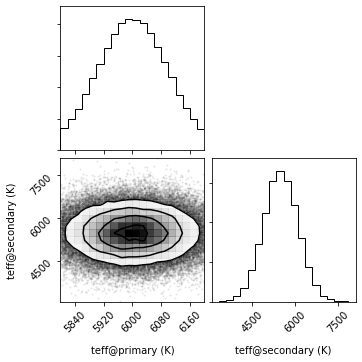

In [15]:
_ = b.plot_distribution_collection('priors@myemceesolver', show=True)

In [16]:
b.calculate_lnp('priors@myemceesolver')

-13.140649347269667

In [17]:
b.set_value('priors_combine', 'first')

Tue, 19 May 2020 11:28 BUNDLE       WARNING no valid distributions in init_from  If not addressed, this warning will continue to be raised and will throw an error at run_solver.


Tue, 19 May 2020 11:28 BUNDLE       WARNING ignoring distribution on teff@primary@star@component with distribution='mydist02' as distribution existed on an earlier distribution which takes precedence.


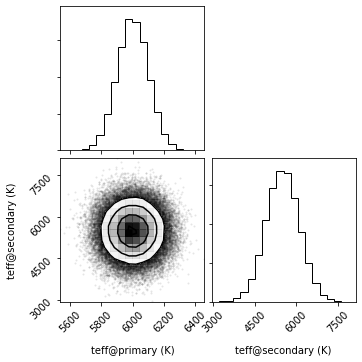

In [18]:
_ = b.plot_distribution_collection('priors@myemceesolver', show=True)

In [19]:
b.calculate_lnp('priors@myemceesolver')

Tue, 19 May 2020 11:28 BUNDLE       WARNING ignoring distribution on teff@primary@star@component with distribution='mydist02' as distribution existed on an earlier distribution which takes precedence.


-13.187199129835806

Next
----------

That's it!! You've completed all the basic tutorials.  Now give PHOEBE a try or dig into some of the advanced tutorials and example scripts.